In [4]:
import torch
from model.model import MoEModel, Config, optimize
from helpers.dimensions_per_feature import compute_dimensions_per_feature, plot_feature_dimensionality_analysis, compute_dimensions_per_feature_single
from helpers.helpers import RouterSelectionHook

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# Dimensions Per Feature

## Demo on Synthetic Data

=== Testing Dimensions Per Feature Analysis ===

--- ANTIPODAL PAIRS ---
Dimensions per feature (D*): 0.750
Frobenius norm²: 4.000
Feature dimensionalities: ['0.500', '0.500', '0.500', '0.500', '0.000']
Antipodal pairs: [(0, 1), (2, 3)]



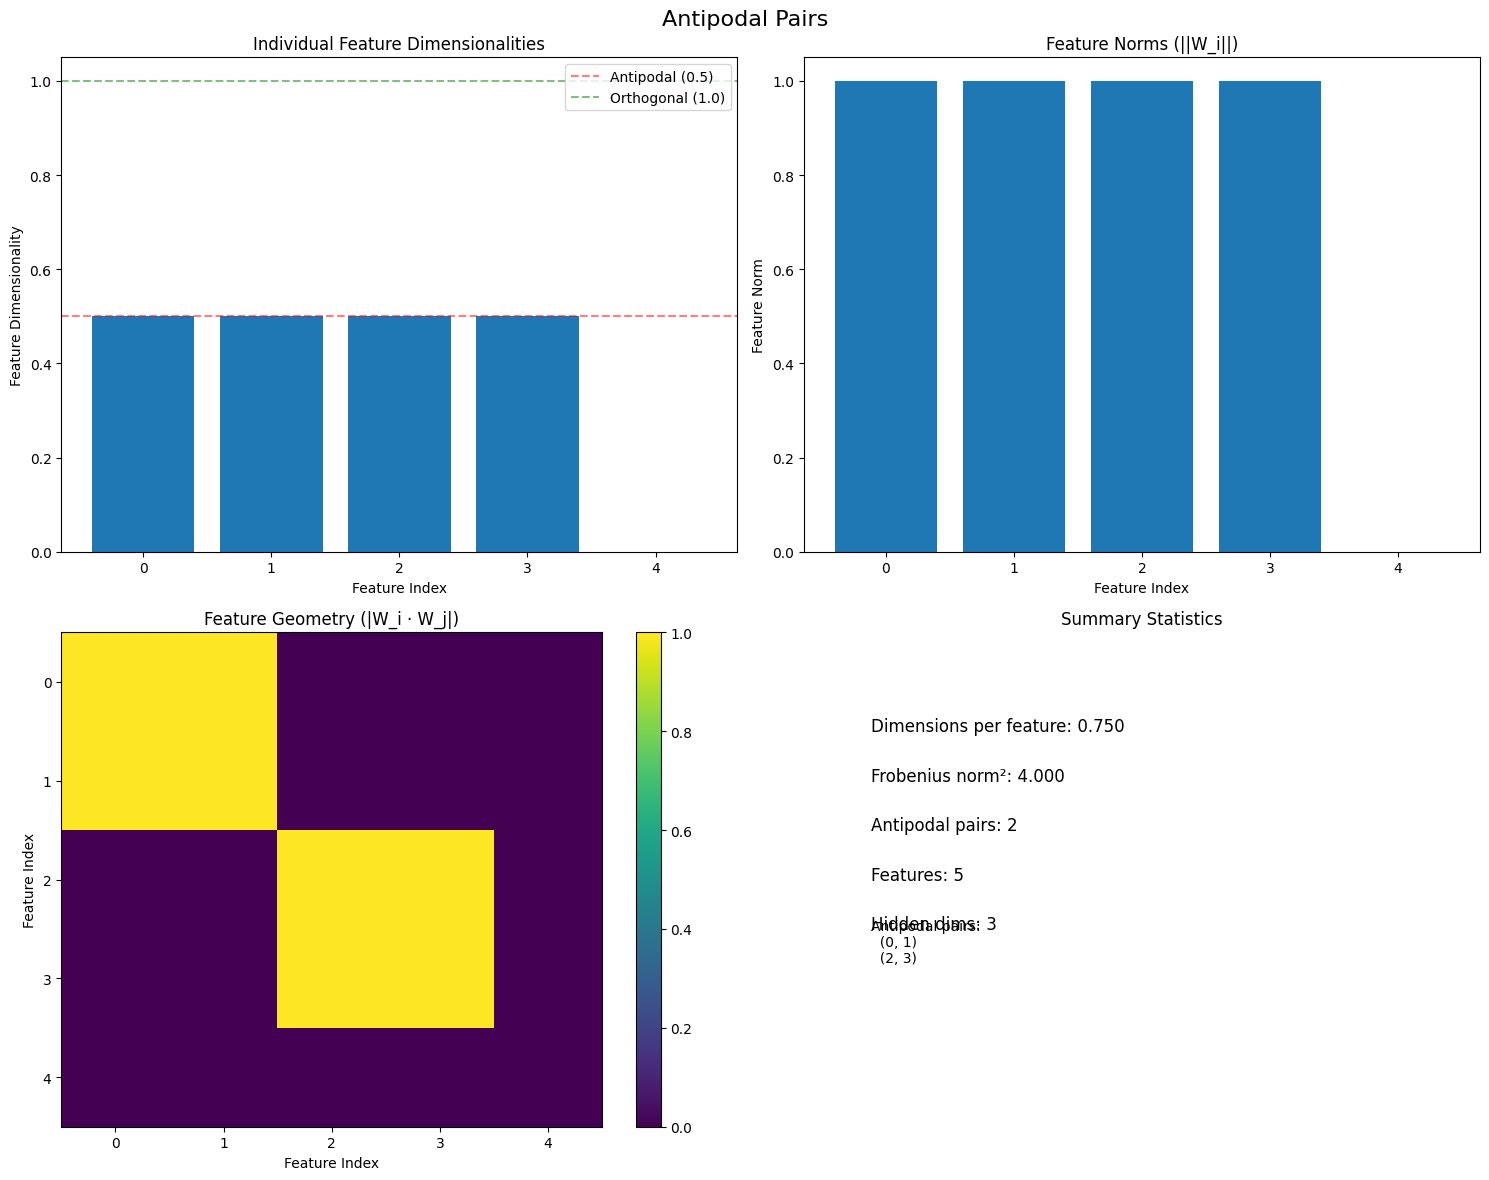

--- ORTHOGONAL FEATURES ---
Dimensions per feature (D*): 1.000
Frobenius norm²: 3.000
Feature dimensionalities: ['1.000', '1.000', '1.000']
Antipodal pairs: []



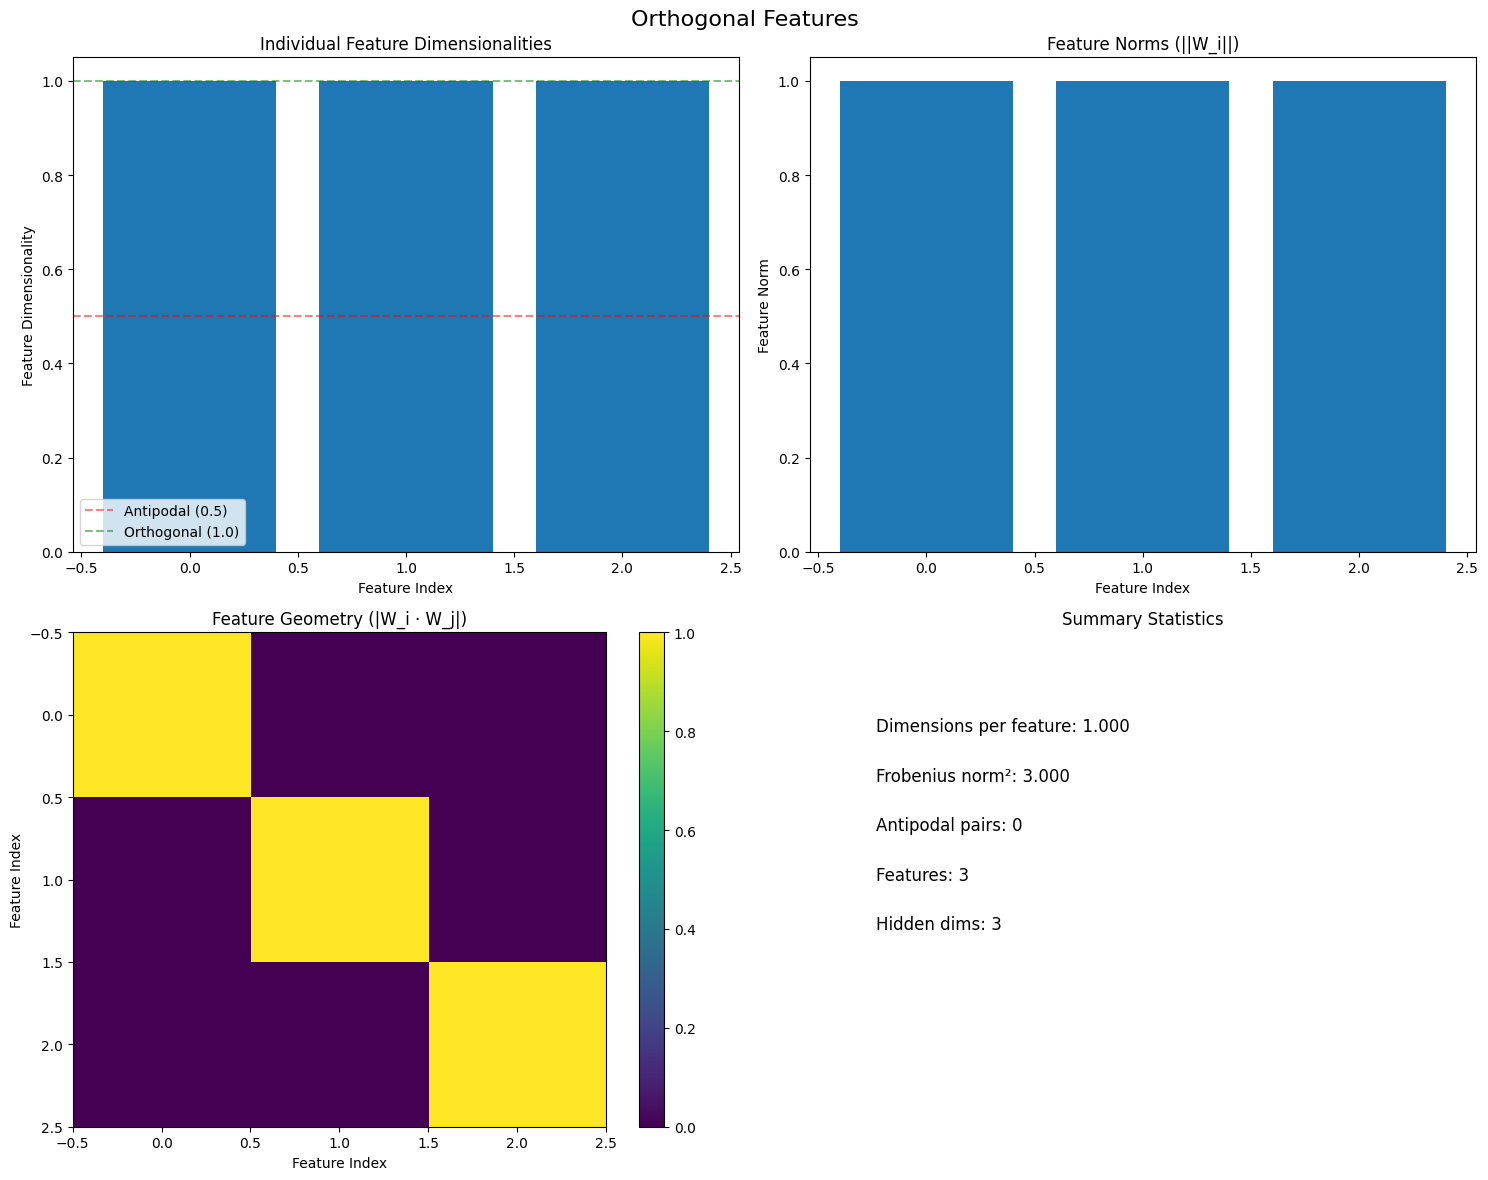

--- MIXED SCENARIO ---
Dimensions per feature (D*): 0.750
Frobenius norm²: 4.000
Feature dimensionalities: ['0.500', '0.500', '1.000', '1.000']
Antipodal pairs: [(0, 1)]



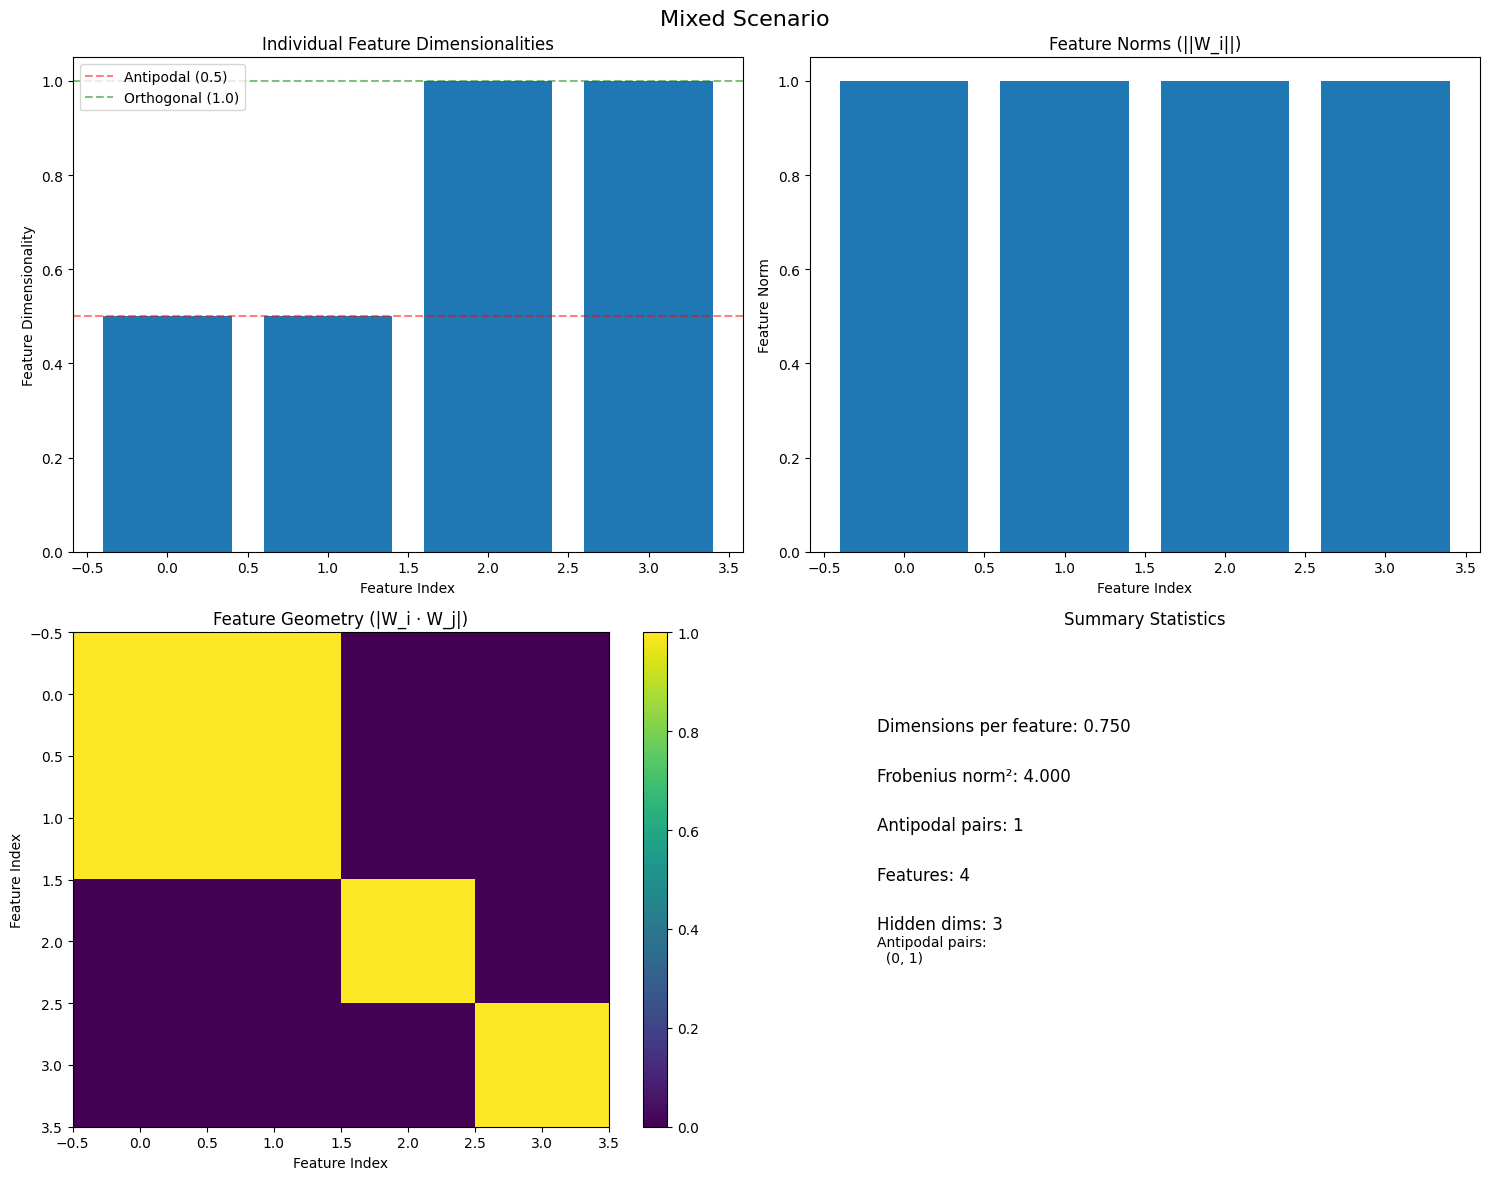

--- INEFFICIENT PACKING ---
Dimensions per feature (D*): 0.639
Frobenius norm²: 3.130
Feature dimensionalities: ['0.610', '0.390', '0.671', '0.329']
Antipodal pairs: []



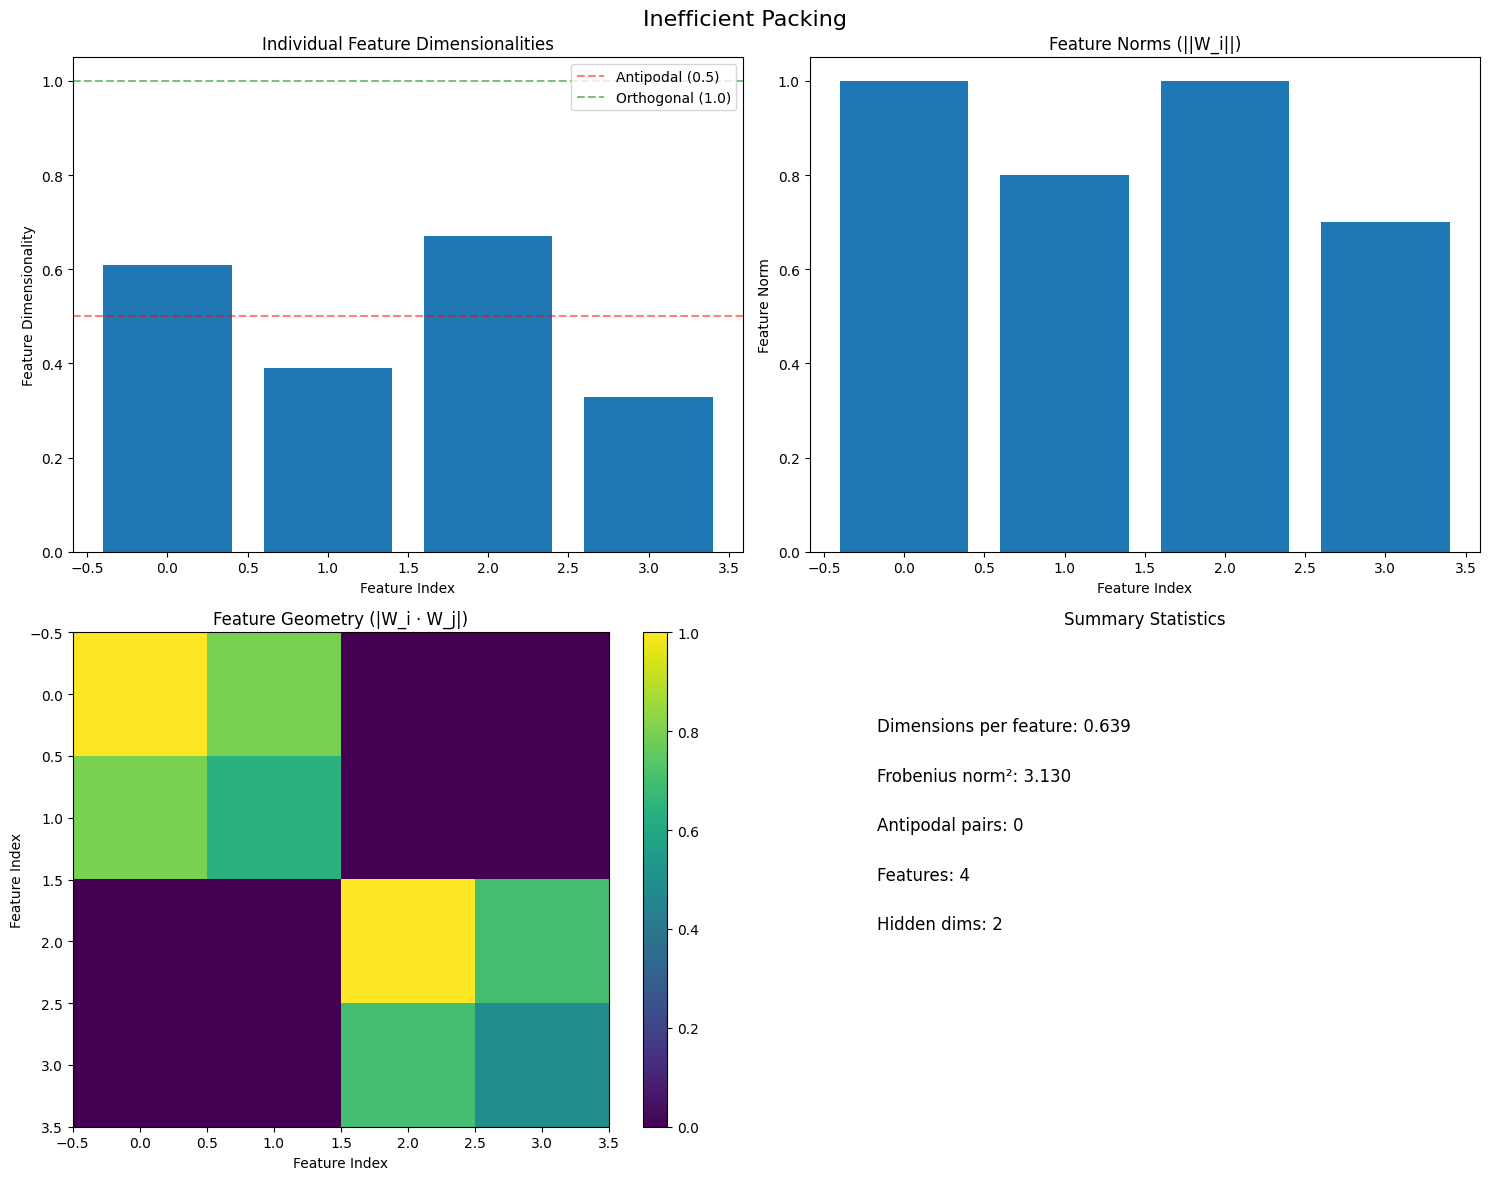

--- SUPERPOSITION ---
Dimensions per feature (D*): 0.667
Frobenius norm²: 3.000
Feature dimensionalities: ['0.500', '0.500', '1.000']
Antipodal pairs: []



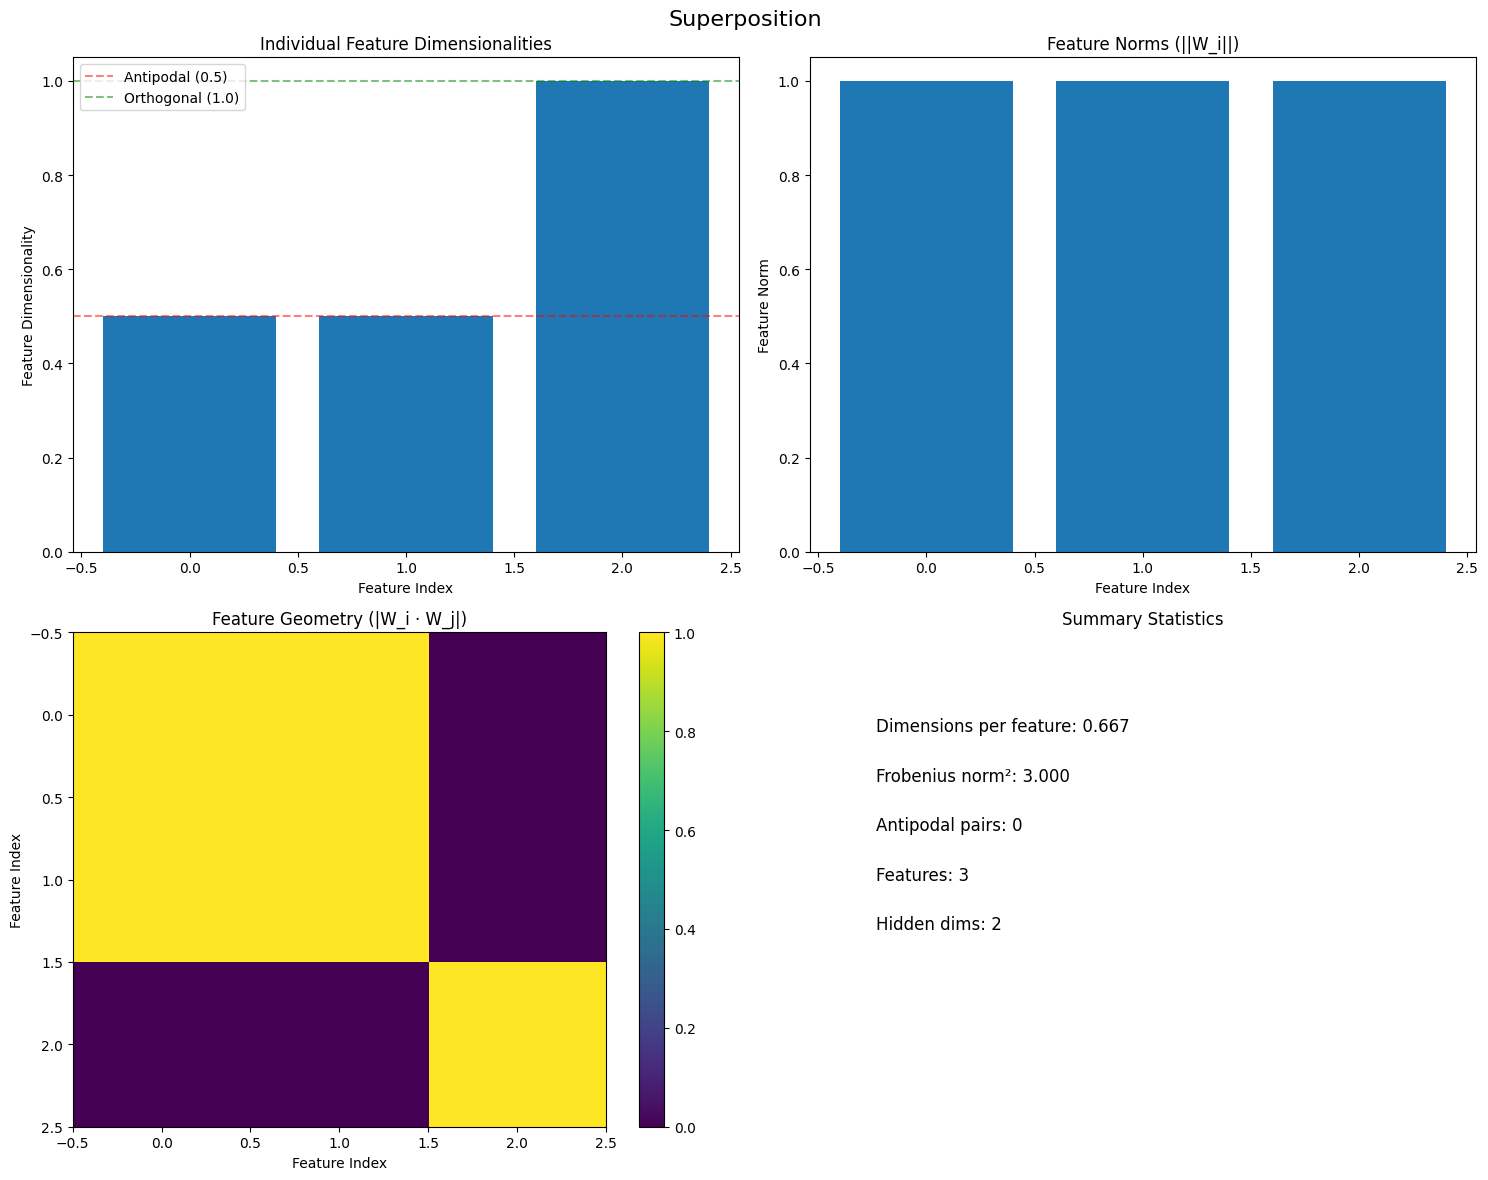

--- RANDOM WEIGHTS ---
Dimensions per feature (D*): 0.915
Frobenius norm²: 3.277
Feature dimensionalities: ['0.045', '0.201', '0.720', '0.257', '0.603']
Antipodal pairs: []



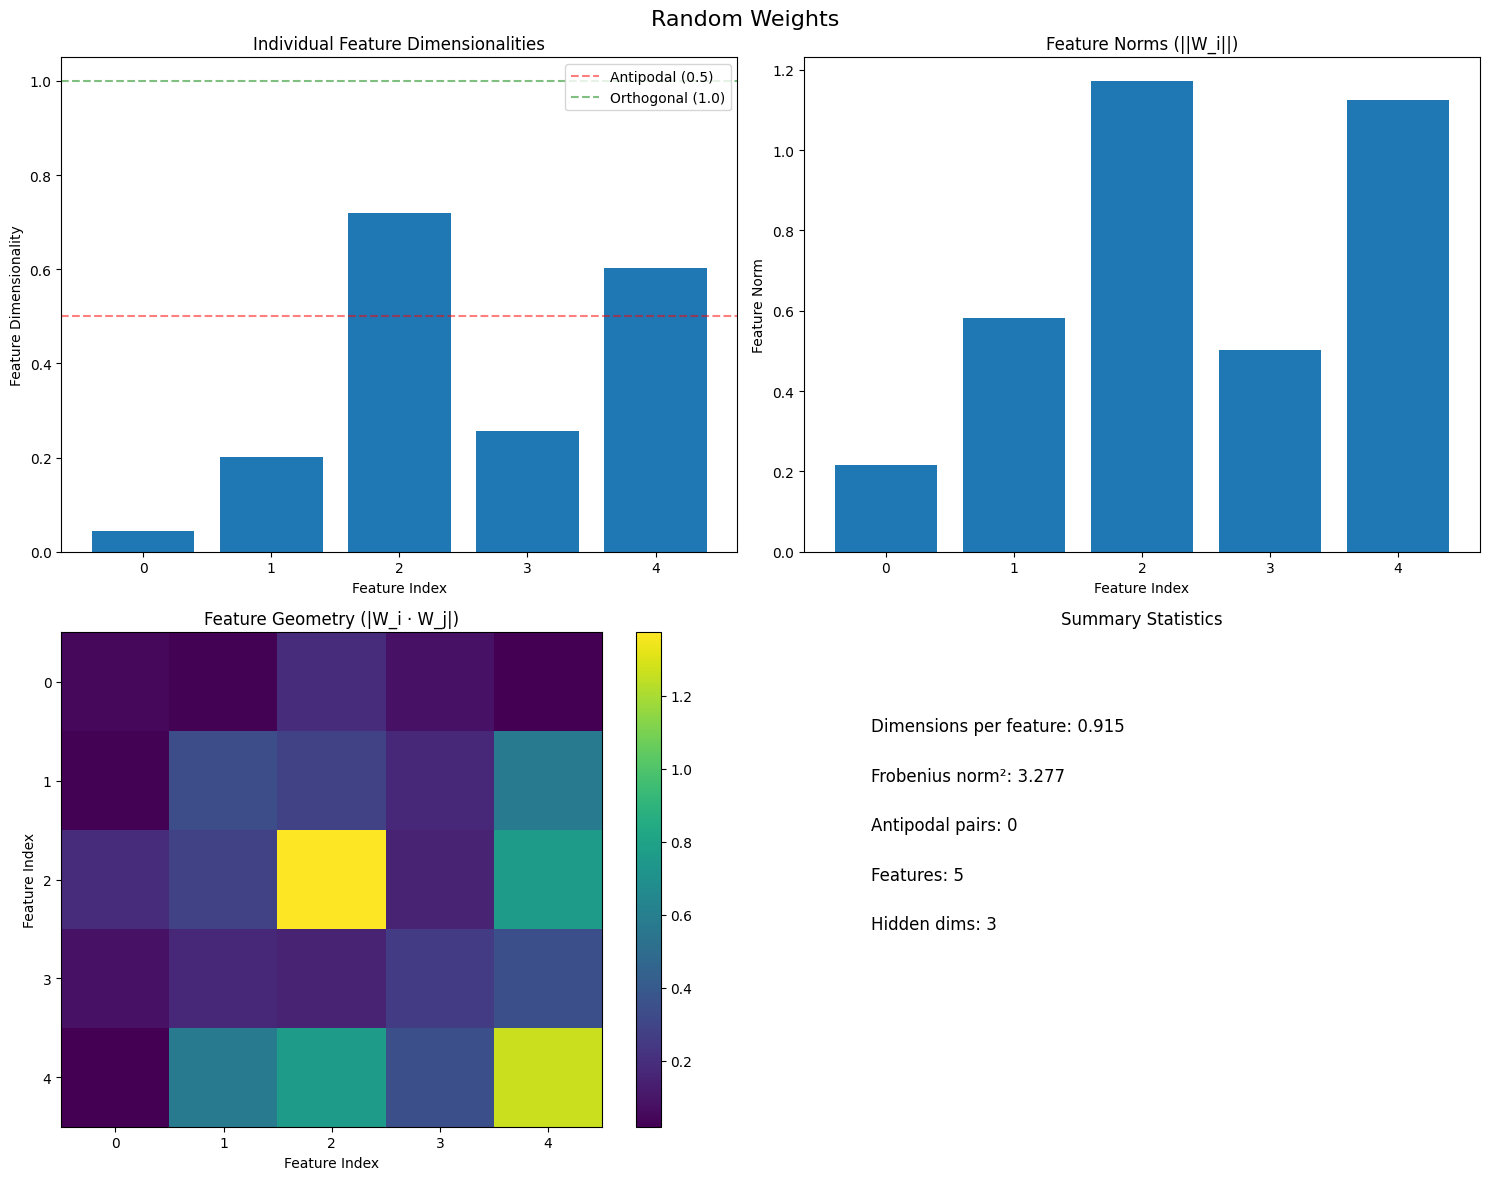

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def create_synthetic_expert_weights():
    """
    Create synthetic expert weight matrices to test different scenarios.
    """
    synthetic_data = {}
    
    # Scenario 1: Perfect antipodal pairs (D* = 1/2)
    # Features 0&1 are antipodal, features 2&3 are antipodal, feature 4 is unused
    antipodal_weights = torch.zeros(5, 3)  # 5 features, 3 hidden dims
    antipodal_weights[0, 0] = 1.0   # Feature 0: [1, 0, 0]
    antipodal_weights[1, 0] = -1.0  # Feature 1: [-1, 0, 0] (antipodal to 0)
    antipodal_weights[2, 1] = 1.0   # Feature 2: [0, 1, 0]
    antipodal_weights[3, 1] = -1.0  # Feature 3: [0, -1, 0] (antipodal to 2)
    antipodal_weights[4, :] = 0.0   # Feature 4: [0, 0, 0] (unused)
    synthetic_data['antipodal_pairs'] = antipodal_weights
    
    # Scenario 2: Perfect orthogonal features (D* = 1)
    # Each feature gets its own dimension
    orthogonal_weights = torch.zeros(3, 3)  # 3 features, 3 hidden dims
    orthogonal_weights[0, 0] = 1.0   # Feature 0: [1, 0, 0]
    orthogonal_weights[1, 1] = 1.0   # Feature 1: [0, 1, 0]
    orthogonal_weights[2, 2] = 1.0   # Feature 2: [0, 0, 1]
    synthetic_data['orthogonal_features'] = orthogonal_weights
    
    # Scenario 3: Mixed scenario (some antipodal, some orthogonal)
    mixed_weights = torch.zeros(4, 3)  # 4 features, 3 hidden dims
    mixed_weights[0, 0] = 1.0   # Feature 0: [1, 0, 0]
    mixed_weights[1, 0] = -1.0  # Feature 1: [-1, 0, 0] (antipodal to 0)
    mixed_weights[2, 1] = 1.0   # Feature 2: [0, 1, 0]
    mixed_weights[3, 2] = 1.0   # Feature 3: [0, 0, 1]
    synthetic_data['mixed_scenario'] = mixed_weights
    
    # Scenario 4: Inefficient packing (overlapping features)
    inefficient_weights = torch.zeros(4, 2)  # 4 features, 2 hidden dims
    inefficient_weights[0, 0] = 1.0   # Feature 0: [1, 0]
    inefficient_weights[1, 0] = 0.8   # Feature 1: [0.8, 0] (overlaps with 0)
    inefficient_weights[2, 1] = 1.0   # Feature 2: [0, 1]
    inefficient_weights[3, 1] = 0.7   # Feature 3: [0, 0.7] (overlaps with 2)
    synthetic_data['inefficient_packing'] = inefficient_weights
    
    # Scenario 5: Superposition scenario (features sharing dimensions)
    superposition_weights = torch.zeros(3, 2)  # 3 features, 2 hidden dims
    superposition_weights[0, 0] = 1.0   # Feature 0: [1, 0]
    superposition_weights[1, 0] = 1.0   # Feature 1: [1, 0] (same as 0)
    superposition_weights[2, 1] = 1.0   # Feature 2: [0, 1]
    synthetic_data['superposition'] = superposition_weights
    
    # Scenario 6: Random weights (realistic scenario)
    torch.manual_seed(42)  # For reproducibility
    random_weights = torch.randn(5, 3) * 0.5  # 5 features, 3 hidden dims
    synthetic_data['random_weights'] = random_weights
    
    return synthetic_data

def test_dimensions_per_feature():
    """
    Test the dimensions per feature analysis with synthetic data.
    """
    synthetic_data = create_synthetic_expert_weights()
    
    print("=== Testing Dimensions Per Feature Analysis ===\n")
    
    for scenario_name, weights in synthetic_data.items():
        print(f"--- {scenario_name.upper().replace('_', ' ')} ---")
        
        # Analyze the weights
        analysis = compute_dimensions_per_feature_single(weights)
        
        # Convert tensors to values for printing
        dimensions_per_feature = analysis['dimensions_per_feature'].item() if torch.is_tensor(analysis['dimensions_per_feature']) else analysis['dimensions_per_feature']
        frobenius_norm = analysis['frobenius_norm_squared'].item() if torch.is_tensor(analysis['frobenius_norm_squared']) else analysis['frobenius_norm_squared']
        feature_dims = [d.item() if torch.is_tensor(d) else d for d in analysis['feature_dimensionalities']]
        
        print(f"Dimensions per feature (D*): {dimensions_per_feature:.3f}")
        print(f"Frobenius norm²: {frobenius_norm:.3f}")
        print(f"Feature dimensionalities: {[f'{d:.3f}' for d in feature_dims]}")
        print(f"Antipodal pairs: {analysis['antipodal_pairs']}")
        print()
        
        # Plot the analysis
        plot_feature_dimensionality_analysis(analysis, title=f"{scenario_name.replace('_', ' ').title()}")
    
    return synthetic_data

# Run the test
synthetic_data = test_dimensions_per_feature()

## Demo Training on Real Model

=== Training Model ===
Step 0: loss=0.634111, lr=0.001000
Step 250: loss=0.375922, lr=0.001000
Step 500: loss=0.270680, lr=0.001000
Step 750: loss=0.266124, lr=0.001000
Step 1000: loss=0.267898, lr=0.001000
Step 1250: loss=0.250523, lr=0.001000
Step 1500: loss=0.241531, lr=0.001000
Step 1750: loss=0.245739, lr=0.001000
Step 2000: loss=0.251560, lr=0.001000
Step 2250: loss=0.255893, lr=0.001000
Step 2500: loss=0.267275, lr=0.001000
Step 2750: loss=0.259320, lr=0.001000
Step 3000: loss=0.225497, lr=0.001000
Step 3250: loss=0.268173, lr=0.001000
Step 3500: loss=0.245968, lr=0.001000
Step 3750: loss=0.292077, lr=0.001000
Step 4000: loss=0.282193, lr=0.001000
Step 4250: loss=0.268207, lr=0.001000
Step 4500: loss=0.261063, lr=0.001000
Step 4750: loss=0.275927, lr=0.001000
Step 4999: loss=0.283105, lr=0.001000

=== Router Selection Statistics ===
Total selections: 5000000
Hook calls: 5000
Average selections per call: 1000.0
Expert counts: {1: 1250175, 0: 1251789, 2: 1248955, 3: 1249081}
Exper

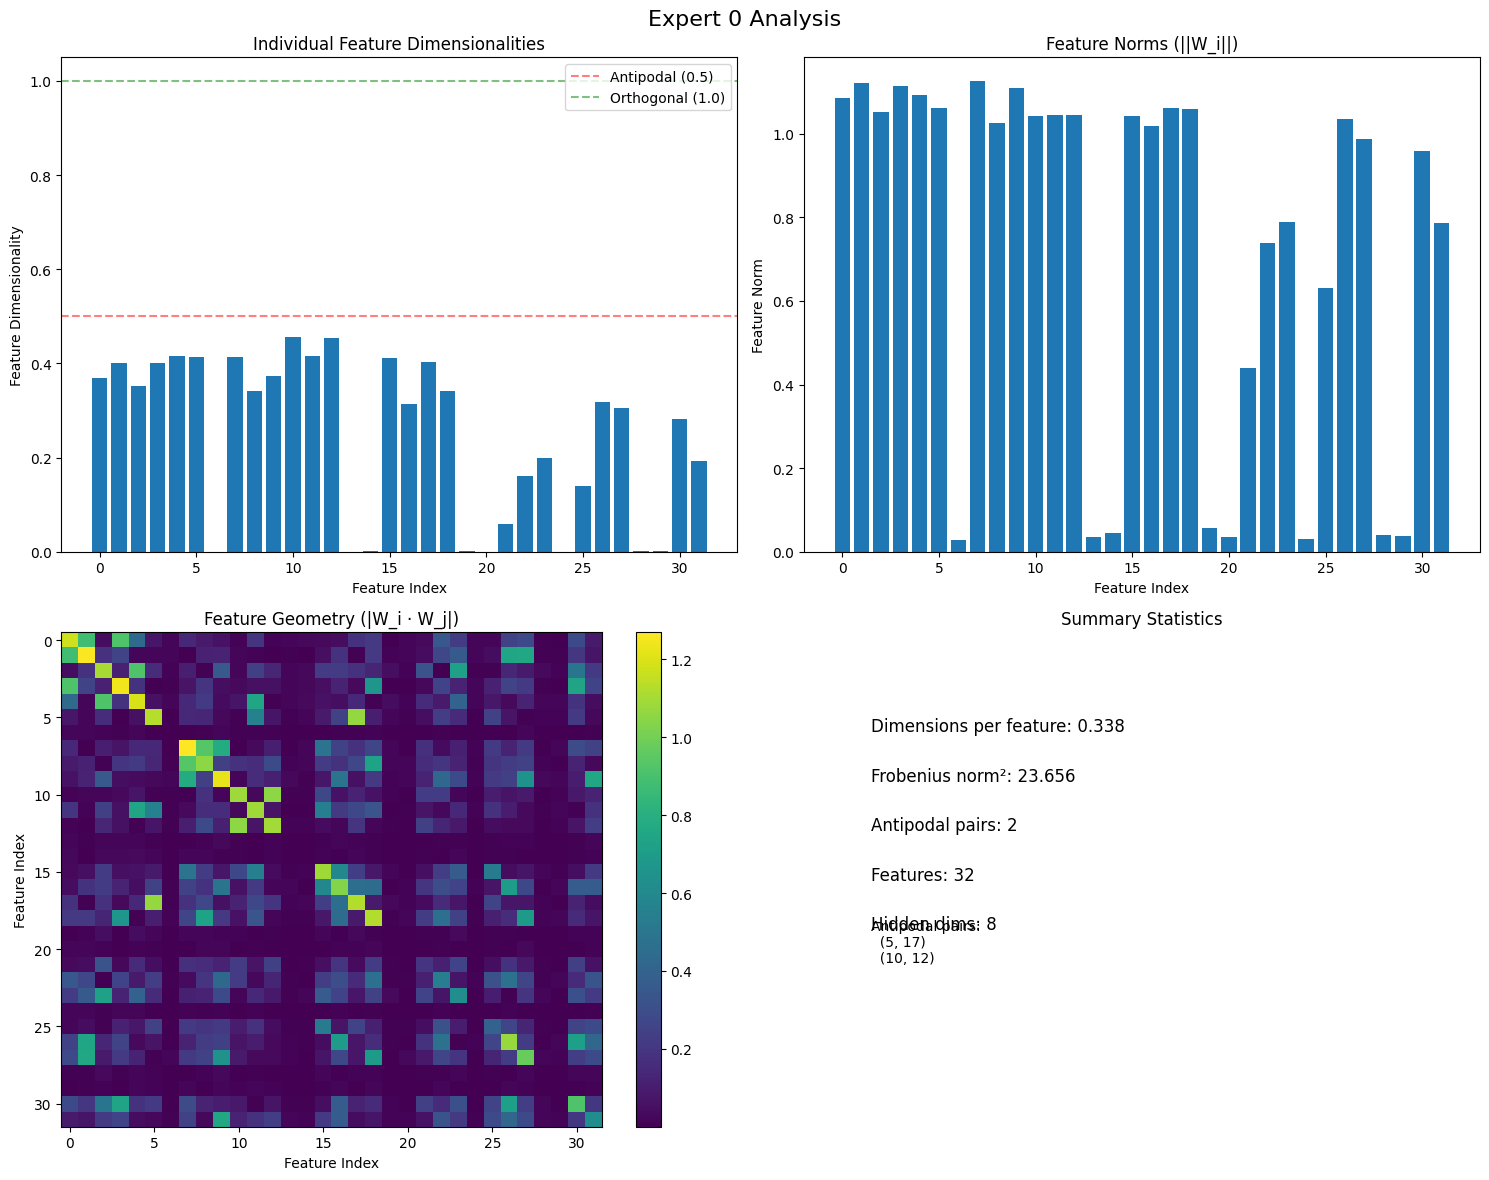

--- EXPERT 1 ---
Dimensions per feature (D*): 0.339
Frobenius norm²: 23.598
Feature dimensionalities: ['0.413', '0.445', '0.000', '0.379', '0.355', '0.304', '0.379', '0.378', '0.389', '0.465', '0.358', '0.346', '0.000', '0.191', '0.312', '0.206', '0.000', '0.368', '0.001', '0.268', '0.411', '0.322', '0.301', '0.000', '0.331', '0.432', '0.000', '0.077', '0.127', '0.069', '0.310', '0.009']
Antipodal pairs: [(1, 20), (9, 25)]



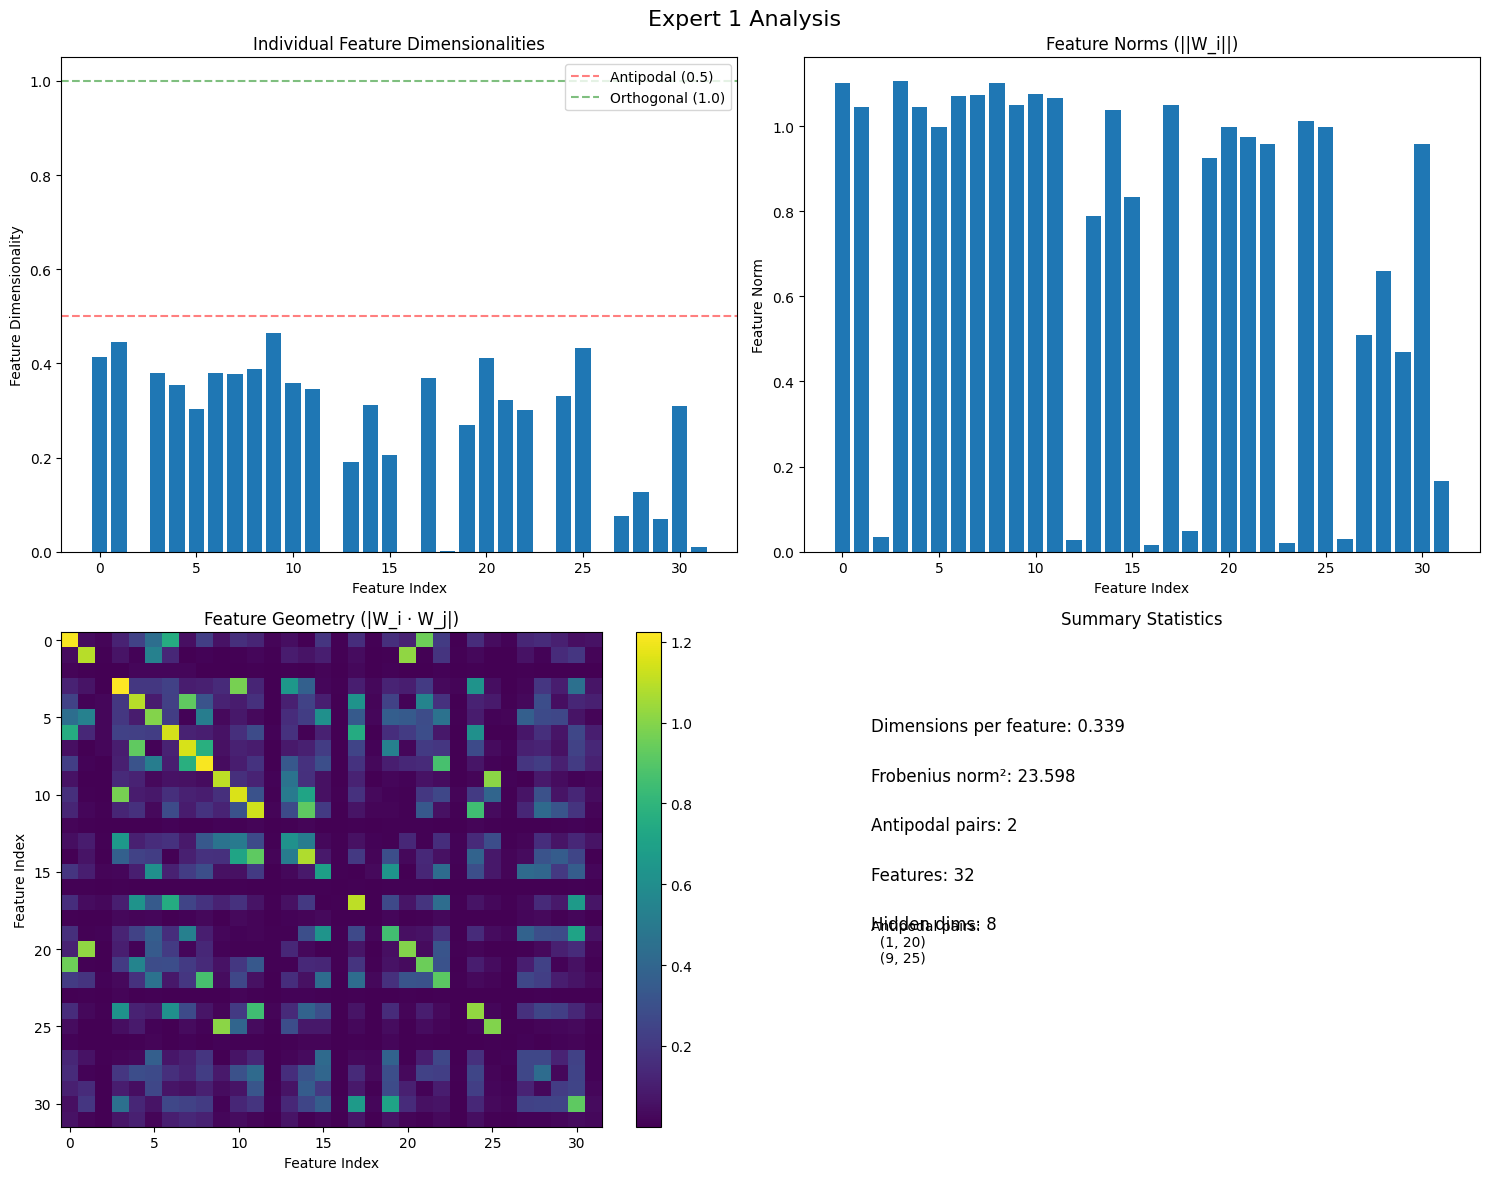

--- EXPERT 2 ---
Dimensions per feature (D*): 0.373
Frobenius norm²: 21.443
Feature dimensionalities: ['0.491', '0.380', '0.477', '0.453', '0.462', '0.423', '0.000', '0.462', '0.420', '0.474', '0.190', '0.413', '0.295', '0.000', '0.340', '0.088', '0.383', '0.373', '0.000', '0.353', '0.450', '0.404', '0.001', '0.001', '0.223', '0.051', '0.000', '0.000', '0.024', '0.000', '0.236', '0.080']
Antipodal pairs: [(0, 9), (2, 4), (3, 11), (5, 21), (7, 20), (10, 29)]



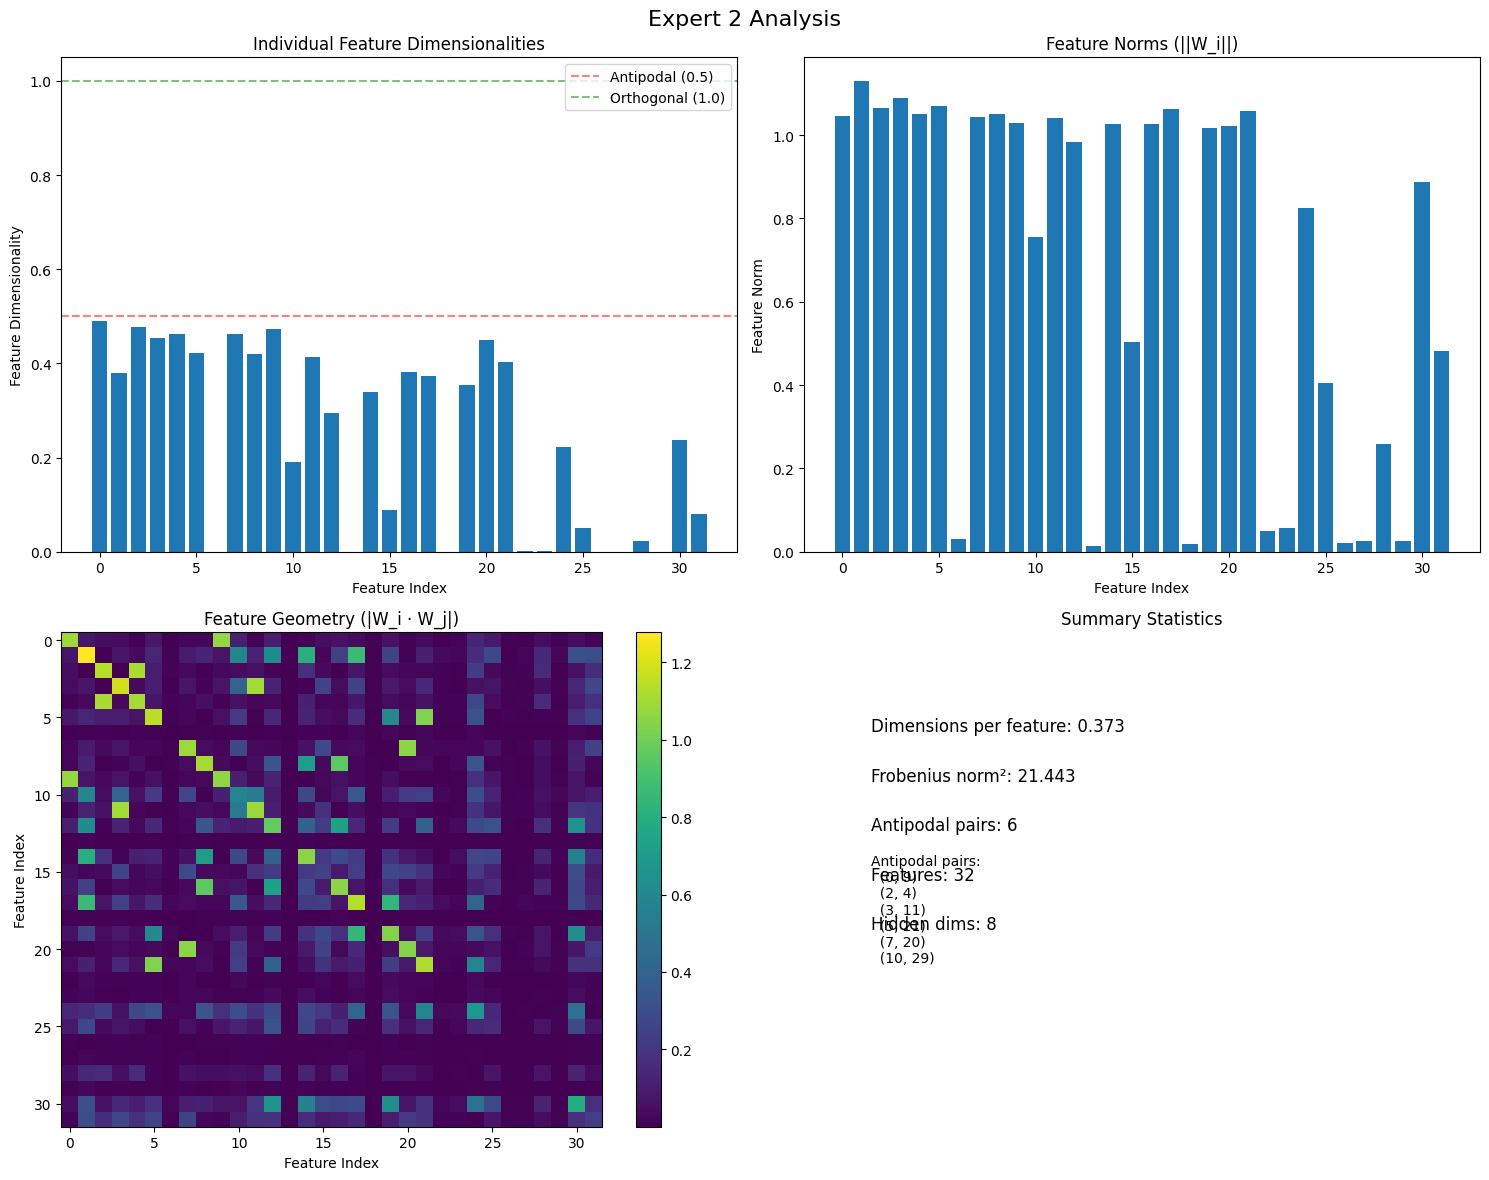

--- EXPERT 3 ---
Dimensions per feature (D*): 0.329
Frobenius norm²: 24.287
Feature dimensionalities: ['0.371', '0.000', '0.404', '0.405', '0.390', '0.382', '0.263', '0.401', '0.333', '0.268', '0.373', '0.212', '0.347', '0.357', '0.415', '0.382', '0.372', '0.000', '0.385', '0.367', '0.113', '0.000', '0.242', '0.348', '0.000', '0.003', '0.290', '0.300', '0.207', '0.000', '0.013', '0.001']
Antipodal pairs: [(14, 18)]



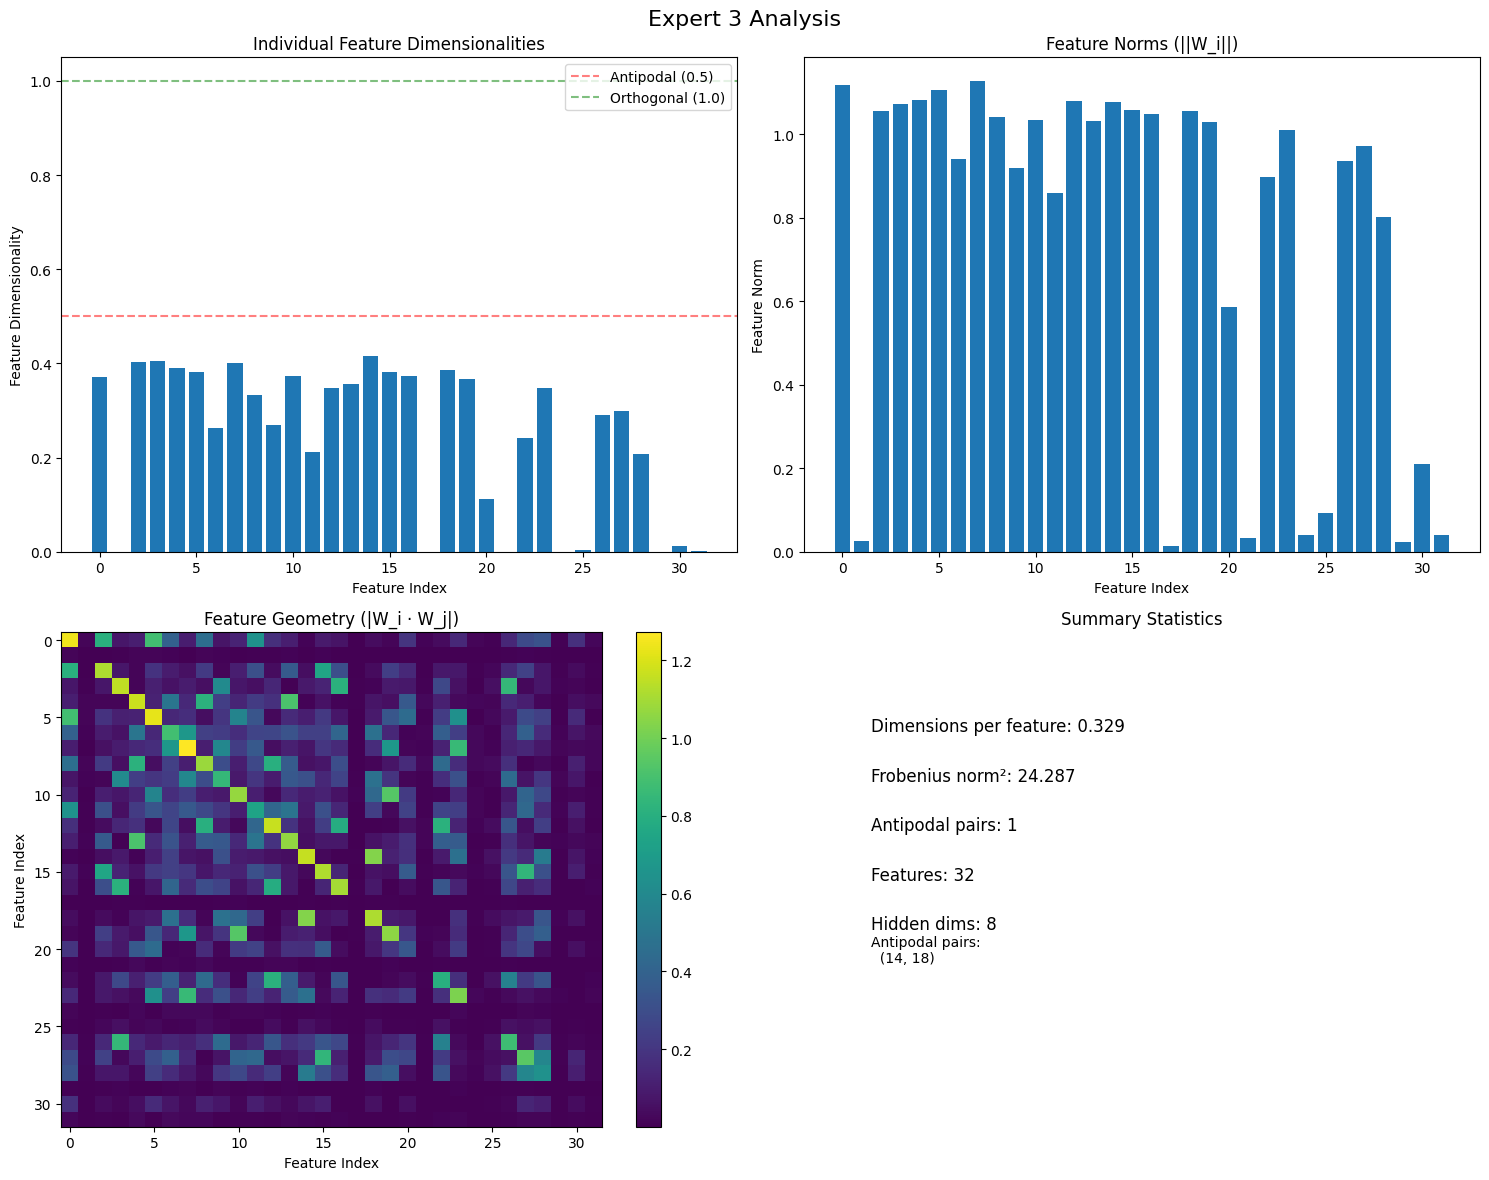

--- ALL EXPERTS COMBINED ---
expert_0: D* = 0.338, ||W||² = 23.656
expert_1: D* = 0.339, ||W||² = 23.598
expert_2: D* = 0.373, ||W||² = 21.443
expert_3: D* = 0.329, ||W||² = 24.287


In [ ]:
def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=32,
        n_hidden=8,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([0.97**i for i in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

# Example usage:
if __name__ == "__main__":
    """
    Test the dimensions per feature analysis with a trained model.
    """
    # Create and train a model
    model = create_model()
    
    print("=== Training Model ===")
    # Train the model (you can add your training loop here)
    # For now, we'll just analyze the initial weights

    # Train the model
    router_hook = RouterSelectionHook()
    optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[router_hook])
    router_hook.print_statistics()

    print("=== Analyzing Dimensions Per Feature ===\n")
    
    # Extract expert weights from the model and detach from computation graph
    expert_weights = model.W_experts.detach()  # Shape: [n_experts, n_features, n_hidden]
    
    # Analyze each expert
    for expert_id in range(expert_weights.shape[0]):
        print(f"--- EXPERT {expert_id} ---")
        
        # Get weights for this expert
        expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
        
        # Analyze the weights
        analysis = compute_dimensions_per_feature_single(expert_weight_matrix)
        
        # Convert tensors to values for printing
        dimensions_per_feature = analysis['dimensions_per_feature'].item() if torch.is_tensor(analysis['dimensions_per_feature']) else analysis['dimensions_per_feature']
        frobenius_norm = analysis['frobenius_norm_squared'].item() if torch.is_tensor(analysis['frobenius_norm_squared']) else analysis['frobenius_norm_squared']
        feature_dims = [d.item() if torch.is_tensor(d) else d for d in analysis['feature_dimensionalities']]
        
        print(f"Dimensions per feature (D*): {dimensions_per_feature:.3f}")
        print(f"Frobenius norm²: {frobenius_norm:.3f}")
        print(f"Feature dimensionalities: {[f'{d:.3f}' for d in feature_dims]}")
        print(f"Antipodal pairs: {analysis['antipodal_pairs']}")
        print()
        
        # Plot the analysis
        plot_feature_dimensionality_analysis(analysis, title=f"Expert {expert_id} Analysis")
    
    # Also analyze all experts together
    print("--- ALL EXPERTS COMBINED ---")
    all_experts_analysis = compute_dimensions_per_feature(expert_weights)
    
    for expert_key, expert_analysis in all_experts_analysis.items():
        dimensions_per_feature = expert_analysis['dimensions_per_feature'].item() if torch.is_tensor(expert_analysis['dimensions_per_feature']) else expert_analysis['dimensions_per_feature']
        frobenius_norm = expert_analysis['frobenius_norm_squared'].item() if torch.is_tensor(expert_analysis['frobenius_norm_squared']) else expert_analysis['frobenius_norm_squared']
        
        print(f"{expert_key}: D* = {dimensions_per_feature:.3f}, ||W||² = {frobenius_norm:.3f}")